# [**Imputation des valeurs manquantes avec des variantes de l'IterativeImputer**](https://nbviewer.org/github/Franck-PepperLabs/pepper_data-science_practising/blob/main/Sklearn/examples/6_4_impute/plot_iterative_imputer_variants_comparison.ipynb)<br/>([_Imputing missing values with variants of IterativeImputer_](https://scikit-learn.org/stable/auto_examples/impute/plot_iterative_imputer_variants_comparison.html))

La classe [**`IterativeImputer`**](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html) est très flexible - elle peut être utilisée avec une variété d'estimateurs pour effectuer une régression en tour à tour, traitant chaque variable comme une sortie à son tour.

Dans cet exemple, nous comparons certains estimateurs dans le but d'imputer des valeurs manquantes de variables avec l'[**`IterativeImputer`**](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html) :

- [**`BayesianRidge`**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html) : régression linéaire régularisée
- [**`RandomForestRegressor`**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) : régression par forêts d'arbres aléatoires
- [**`Nystroem`**](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.Nystroem.html), [**`Ridge`**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) : un pipeline avec l'expansion d'un noyau polynomial de degré 2 et une régression linéaire régularisée
- [**`KNeighborsRegressor`**](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html) : comparable à d'autres approches d'imputation KNN

D'un intérêt particulier est la capacité de l'[**`IterativeImputer`**](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html) à imiter le comportement de _missForest_, un package populaire d'imputation pour R.

Notez que [**`KNeighborsRegressor`**](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html) est différent de l'imputation KNN, qui apprend à partir d'échantillons avec des valeurs manquantes en utilisant une mesure de distance qui tient compte des valeurs manquantes, plutôt que de les imputer.

L'objectif est de comparer différents estimateurs pour voir lequel est le meilleur pour l'[**`KNeighborsRegressor`**](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html) lorsqu'on utilise un estimateur [**`BayesianRidge`**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html) sur l'ensemble de données du logement en Californie avec une seule valeur supprimée de manière aléatoire dans chaque ligne.

Pour ce motif particulier de valeurs manquantes, nous constatons que [**`BayesianRidge`**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html) et [**`RandomForestRegressor`**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) donnent les meilleurs résultats.

Il convient de noter que certains estimateurs tels que [**`HistGradientBoostingRegressor`**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html#sklearn.ensemble.HistGradientBoostingRegressor) peuvent gérer nativement les variables manquantes et sont souvent recommandés plutôt que de construire des pipelines avec des stratégies complexes et coûteuses d'imputation des valeurs manquantes.

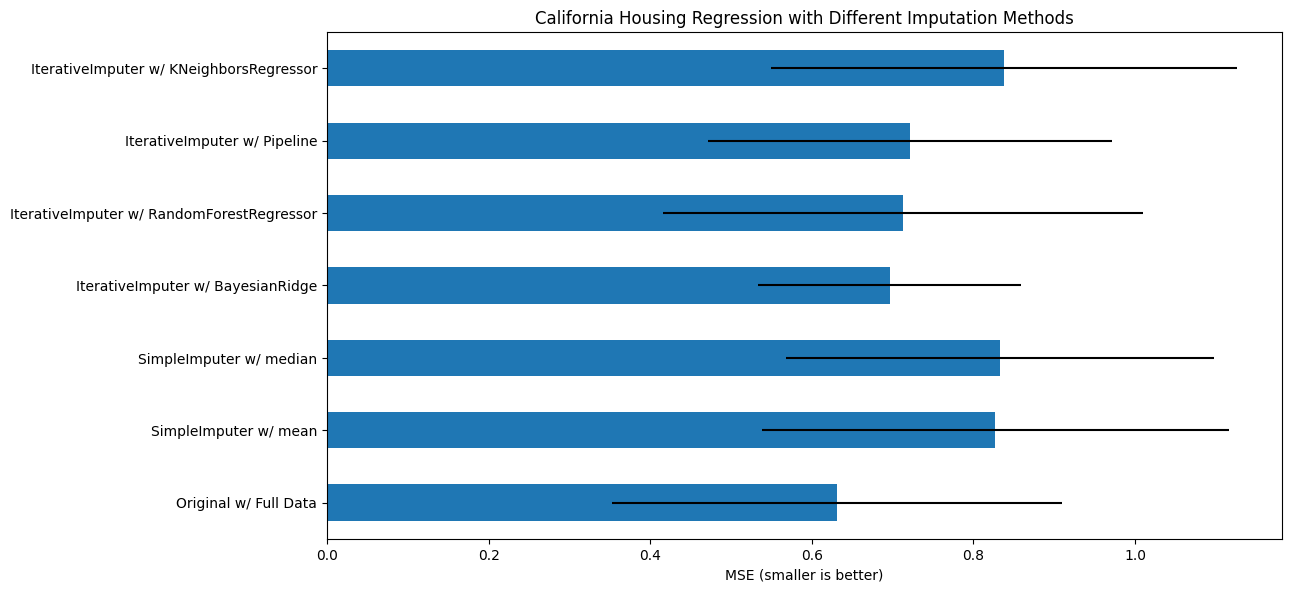

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# To use this experimental feature, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.datasets import fetch_california_housing
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.kernel_approximation import Nystroem
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

N_SPLITS = 5

rng = np.random.RandomState(0)

X_full, y_full = fetch_california_housing(return_X_y=True)
# ~2k samples is enough for the purpose of the example.
# Remove the following two lines for a slower run with different error bars.
X_full = X_full[::10]
y_full = y_full[::10]
n_samples, n_features = X_full.shape

# Estimate the score on the entire dataset, with no missing values
br_estimator = BayesianRidge()
score_full_data = pd.DataFrame(
    cross_val_score(
        br_estimator, X_full, y_full, scoring="neg_mean_squared_error", cv=N_SPLITS
    ),
    columns=["Full Data"],
)

# Add a single missing value to each row
X_missing = X_full.copy()
y_missing = y_full
missing_samples = np.arange(n_samples)
missing_features = rng.choice(n_features, n_samples, replace=True)
X_missing[missing_samples, missing_features] = np.nan

# Estimate the score after imputation (mean and median strategies)
score_simple_imputer = pd.DataFrame()
for strategy in ("mean", "median"):
    estimator = make_pipeline(
        SimpleImputer(missing_values=np.nan, strategy=strategy), br_estimator
    )
    score_simple_imputer[strategy] = cross_val_score(
        estimator, X_missing, y_missing, scoring="neg_mean_squared_error", cv=N_SPLITS
    )

# Estimate the score after iterative imputation of the missing values
# with different estimators
estimators = [
    BayesianRidge(),
    RandomForestRegressor(
        # We tuned the hyperparameters of the RandomForestRegressor to get a good
        # enough predictive performance for a restricted execution time.
        n_estimators=4,
        max_depth=10,
        bootstrap=True,
        max_samples=0.5,
        n_jobs=2,
        random_state=0,
    ),
    make_pipeline(
        Nystroem(kernel="polynomial", degree=2, random_state=0), Ridge(alpha=1e3)
    ),
    KNeighborsRegressor(n_neighbors=15),
]
score_iterative_imputer = pd.DataFrame()
# iterative imputer is sensible to the tolerance and
# dependent on the estimator used internally.
# we tuned the tolerance to keep this example run with limited computational
# resources while not changing the results too much compared to keeping the
# stricter default value for the tolerance parameter.
tolerances = (1e-3, 1e-1, 1e-1, 1e-2)
for impute_estimator, tol in zip(estimators, tolerances):
    estimator = make_pipeline(
        IterativeImputer(
            random_state=0, estimator=impute_estimator, max_iter=25, tol=tol
        ),
        br_estimator,
    )
    score_iterative_imputer[impute_estimator.__class__.__name__] = cross_val_score(
        estimator, X_missing, y_missing, scoring="neg_mean_squared_error", cv=N_SPLITS
    )

scores = pd.concat(
    [score_full_data, score_simple_imputer, score_iterative_imputer],
    keys=["Original", "SimpleImputer", "IterativeImputer"],
    axis=1,
)

# plot california housing results
fig, ax = plt.subplots(figsize=(13, 6))
means = -scores.mean()
errors = scores.std()
means.plot.barh(xerr=errors, ax=ax)
ax.set_title("California Housing Regression with Different Imputation Methods")
ax.set_xlabel("MSE (smaller is better)")
ax.set_yticks(np.arange(means.shape[0]))
ax.set_yticklabels([" w/ ".join(label) for label in means.index.tolist()])
plt.tight_layout(pad=1)
plt.show()